In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score, cross_val_predict, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from yellowbrick.text import TSNEVisualizer
from sklearn.pipeline import Pipeline
from sentence_transformers import SentenceTransformer
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import accuracy_score

# Classification automatique des biens de consommations 

In [2]:
im = pd.read_csv("im1.csv")

In [3]:
im.head(2)

,Unnamed: 0,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,...,description,product_rating,overall_rating,brand,product_specifications,target,description_cleaned,word_count,description_cleaned_bis,description_cleaned_lem
0,0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,...,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",HomeFurnishing,key featur eleg polyest multicolor abstract ey...,162,key eleg polyest multicolor abstract eyelet do...,key elegance polyester multicolor abstract eye...
1,1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,...,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",BabyCare,specif sathiya cotton bath towel bath towel re...,64,specif sathiya cotton bath towel bath towel re...,specifications sathiyas cotton bath towel bath...


In [4]:
X_train_stem, X_test_stem, y_train_stem, y_test_stem = train_test_split(im['description_cleaned'],im['target'], test_size=0.2)

In [5]:
print(X_train_stem.shape)
print(X_test_stem.shape)
print(y_train_stem.shape)
print(y_test_stem.shape)

(840,)
(210,)
(840,)
(210,)


TfidfVectorizer est équivalent a CountVectorizer et TfidfTransformer
Tfidf va nous permettre de faire resortir les mots qui caractérise chacun des catégories de produits et donc on va pouvoir les **comparer**. on va appliquer par la suite un tsne pour voir les **similarités entre classes**

In [6]:
vectorizer = TfidfVectorizer()
X_train_stem = vectorizer.fit_transform(X_train_stem)
X_test_stem = vectorizer.transform(X_test_stem)

In [7]:
print(X_train_stem.shape)
print(y_train_stem.shape) 
print(X_test_stem.shape)
print(y_test_stem.shape) 

(840, 3787)
(840,)
(210, 3787)
(210,)


## Réduction dimensionnelle TSNE sur le jeu de donnée BOW Stem+TFIDFVectorizer

In [8]:
tsne_stem = TSNE(n_components=2, perplexity=80, early_exaggeration= 120, learning_rate=200, n_iter=7000, verbose = 1 )
tsne_transform_stem = tsne_stem.fit_transform(X_train_stem)

[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 840 samples in 0.001s...
[t-SNE] Computed neighbors for 840 samples in 0.083s...
[t-SNE] Computed conditional probabilities for sample 840 / 840
[t-SNE] Mean sigma: 0.401758
[t-SNE] KL divergence after 250 iterations with early exaggeration: 1000.173706
[t-SNE] KL divergence after 3550 iterations: 0.677887


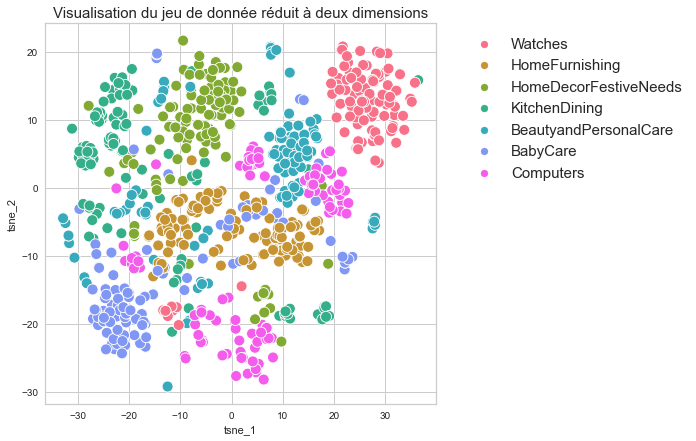

In [9]:
tsne_stem_result_df = pd.DataFrame({'tsne_1': tsne_transform_stem[:,0], 'tsne_2': tsne_transform_stem[:,1], 'label': y_train_stem})
plt.figure(figsize = (7,7))
sns.scatterplot(x='tsne_1', y='tsne_2',hue='label', data=tsne_stem_result_df,s=120)
plt.title("Visualisation du jeu de donnée réduit à deux dimensions", fontsize = 15)
plt.legend(bbox_to_anchor=(1.05, 1),loc = 'best', fontsize = 15)

La tsne a permis de bien différencier surtout une catégorie : watches 

## Clustering 

In [10]:
modele_stem = KMeans(n_clusters = 7) 
kmean_stem = modele_stem.fit(tsne_transform_stem)

In [11]:
centroids = kmean_stem.cluster_centers_
print(centroids)

[[ -9.068084    -5.932739  ]
 [ 26.561672    12.93522   ]
 [ -3.4831138   12.834366  ]
 [  4.47612    -19.739895  ]
 [-23.249083     6.000881  ]
 [ 12.934669    -0.71804214]
 [-20.568806   -16.564606  ]]


In [12]:
from sklearn import metrics
labels = kmean_stem.labels_
metrics.silhouette_score(tsne_transform_stem, labels, metric='euclidean')

0.42787606

In [13]:
y_km = kmean_stem.fit_predict(tsne_transform_stem)

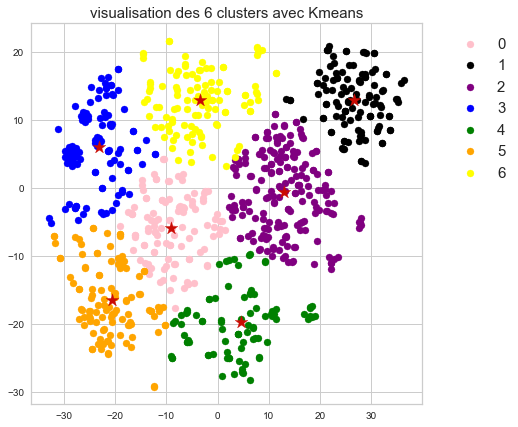

In [14]:
filtered_label0 = tsne_transform_stem[y_km == 0]
filtered_label1 = tsne_transform_stem[y_km == 1]
filtered_label2 = tsne_transform_stem[y_km == 2]
filtered_label3 = tsne_transform_stem[y_km == 3]
filtered_label4 = tsne_transform_stem[y_km == 4]
filtered_label5 = tsne_transform_stem[y_km == 5]
filtered_label6 = tsne_transform_stem[y_km == 6]

centroide = kmean_stem.cluster_centers_
#plotting the results
plt.figure(figsize = (7,7))
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1],color = 'pink', label = 0)
plt.scatter(filtered_label1[:,0] , filtered_label1[:,1], color = 'black', label = 1)
plt.scatter(filtered_label2[:,0] , filtered_label2[:,1], color= 'purple', label = 2)
plt.scatter(filtered_label3[:,0] , filtered_label3[:,1], color = 'blue', label = 3)
plt.scatter(filtered_label4[:,0] , filtered_label4[:,1], color = 'green', label =4)
plt.scatter(filtered_label5[:,0] , filtered_label5[:,1], color = 'orange', label =5)
plt.scatter(filtered_label6[:,0] , filtered_label6[:,1], color = 'yellow', label =6)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 180, color = 'r',marker = '*')
plt.title("visualisation des 6 clusters avec Kmeans", fontsize = 15)
plt.legend(bbox_to_anchor=(1.05, 1),loc = 'best', fontsize = 15)
plt.show()

In [15]:
ARI_stem = adjusted_rand_score(y_train_stem,kmean_stem.labels_)
ARI_stem

0.36960116514833985

In [16]:
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(im['description_cleaned_lem'],im['target'], test_size=0.2)

In [17]:
vectorizer = TfidfVectorizer()
X_train_lem = vectorizer.fit_transform(X_train_lem)
X_test_lem = vectorizer.transform(X_test_lem)

## Réduction dimensionnelle TSNE sur le jeu de donnée BOW Lemmatisation+TFIDFVectorizer

In [18]:
tsne_lem = TSNE(n_components=2, perplexity=80, early_exaggeration= 120, learning_rate=200, n_iter=7000, verbose = 1 )
tsne_transform_lem = tsne_lem.fit_transform(X_train_lem)

[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 840 samples in 0.000s...
[t-SNE] Computed neighbors for 840 samples in 0.071s...
[t-SNE] Computed conditional probabilities for sample 840 / 840
[t-SNE] Mean sigma: 0.399799
[t-SNE] KL divergence after 250 iterations with early exaggeration: 1013.779419
[t-SNE] KL divergence after 1750 iterations: 0.707404


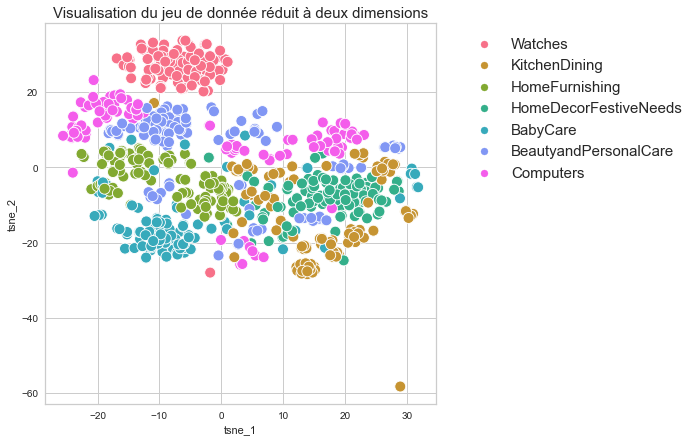

In [19]:
tsne_lem_result_df = pd.DataFrame({'tsne_1': tsne_transform_lem[:,0], 'tsne_2': tsne_transform_lem[:,1], 'label': y_train_lem})
plt.figure(figsize = (7,7))
sns.scatterplot(x='tsne_1', y='tsne_2',hue='label', data=tsne_lem_result_df,s=120)
plt.title("Visualisation du jeu de donnée réduit à deux dimensions", fontsize = 15)
plt.legend(bbox_to_anchor=(1.05, 1),loc = 'best', fontsize = 15)

Avec la méthode lemmatisation, on remarque que le jeu de donnée est plus condensé, les produits plus rapproché les uns des autres. La catégorie watch et Baby Care sont les mieux représenté par cette réduction dimensionnelle

## Clustering 

In [20]:
modele_lem = KMeans(n_clusters = 7) 
kmean_lem = modele_lem.fit(tsne_transform_lem)

In [21]:
from sklearn import metrics
labels = kmean_lem.labels_
metrics.silhouette_score(tsne_transform_lem, labels, metric='euclidean')

0.4175832

In [22]:
y_km = kmean_lem.fit_predict(tsne_transform_lem)

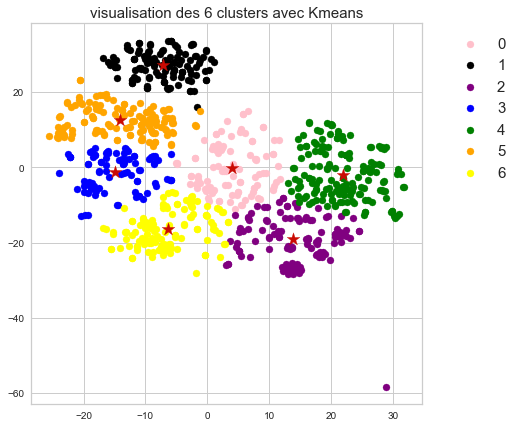

In [23]:
filtered_label0 = tsne_transform_lem[y_km == 0]
filtered_label1 = tsne_transform_lem[y_km == 1]
filtered_label2 = tsne_transform_lem[y_km == 2]
filtered_label3 = tsne_transform_lem[y_km == 3]
filtered_label4 = tsne_transform_lem[y_km == 4]
filtered_label5 = tsne_transform_lem[y_km == 5]
filtered_label6 = tsne_transform_lem[y_km == 6]

centroids = kmean_lem.cluster_centers_
#plotting the results
plt.figure(figsize = (7,7))
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1],color = 'pink', label = 0)
plt.scatter(filtered_label1[:,0] , filtered_label1[:,1], color = 'black', label = 1)
plt.scatter(filtered_label2[:,0] , filtered_label2[:,1], color= 'purple', label = 2)
plt.scatter(filtered_label3[:,0] , filtered_label3[:,1], color = 'blue', label = 3)
plt.scatter(filtered_label4[:,0] , filtered_label4[:,1], color = 'green', label =4)
plt.scatter(filtered_label5[:,0] , filtered_label5[:,1], color = 'orange', label =5)
plt.scatter(filtered_label6[:,0] , filtered_label6[:,1], color = 'yellow', label =6)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 180, color = 'r',marker = '*')
plt.title("visualisation des 6 clusters avec Kmeans", fontsize = 15)
plt.legend(bbox_to_anchor=(1.05, 1),loc = 'best', fontsize = 15)
plt.show()

In [24]:
ARI_lem = adjusted_rand_score(y_train_lem,kmean_lem.labels_)
ARI_lem

0.37830076945952856

In [25]:
emb0 = pd.read_csv('emb0.csv')
emb1 = pd.read_csv('emb1.csv')
emb2 = pd.read_csv('emb2.csv')

## Réduction dimensionnelle TSNE sur le jeu de donnée word embedding non nettoyé

In [26]:
tsne = TSNE(n_components=2, perplexity=80, early_exaggeration= 120, learning_rate=200, n_iter=7000, verbose = 1 )
tsne_embedding0_transform = tsne.fit_transform(emb0)

[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.069s...
[t-SNE] Computed neighbors for 1050 samples in 0.778s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 1.756238
[t-SNE] KL divergence after 250 iterations with early exaggeration: 1015.694702
[t-SNE] KL divergence after 3500 iterations: 0.774879


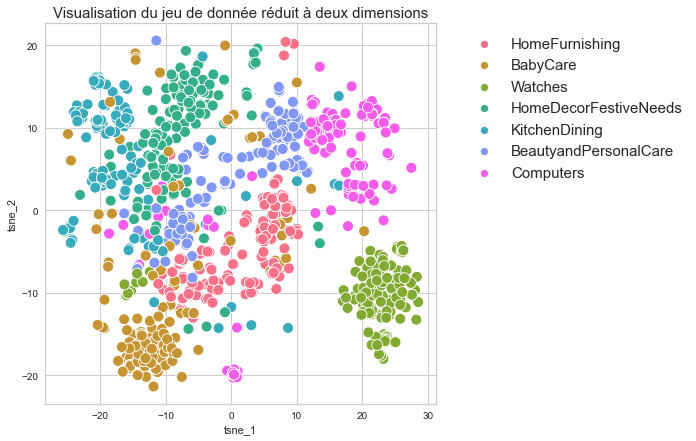

In [27]:
tsne_embedding0_result_df = pd.DataFrame({'tsne_1': tsne_embedding0_transform[:,0], 'tsne_2': tsne_embedding0_transform[:,1], 'label': im['target']})
plt.figure(figsize = (7,7))
sns.scatterplot(x='tsne_1', y='tsne_2',hue='label', data=tsne_embedding0_result_df,s=120)
plt.title("Visualisation du jeu de donnée réduit à deux dimensions", fontsize = 15)
plt.legend(bbox_to_anchor=(1.05, 1),loc = 'best', fontsize = 15)

## Clustering 

In [28]:
modele_emb0 = KMeans(n_clusters = 7) 
kmeans_emb0 = modele_emb0.fit(tsne_embedding0_transform)

In [29]:
labels_emb0 = kmeans_emb0.labels_
metrics.silhouette_score(tsne_embedding0_transform, labels_emb0, metric='euclidean')

0.45052072

In [30]:
y_km = kmeans_emb0.fit_predict(tsne_embedding0_transform)
print(y_km)

[6 0 4 ... 3 5 3]


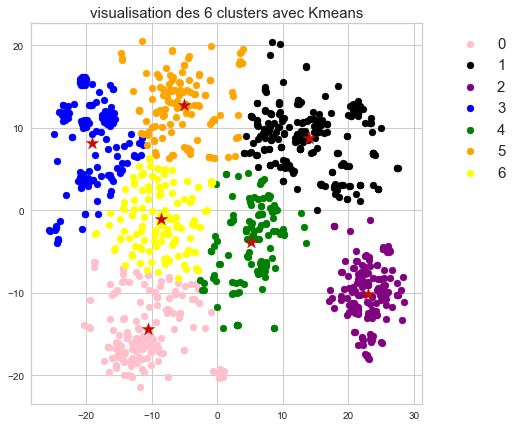

In [31]:
filtered_label0 = tsne_embedding0_transform[y_km == 0]
filtered_label1 = tsne_embedding0_transform[y_km == 1]
filtered_label2 = tsne_embedding0_transform[y_km == 2]
filtered_label3 = tsne_embedding0_transform[y_km == 3]
filtered_label4 = tsne_embedding0_transform[y_km == 4]
filtered_label5 = tsne_embedding0_transform[y_km == 5]
filtered_label6 = tsne_embedding0_transform[y_km == 6]

centroide = kmeans_emb0.cluster_centers_
#plotting the results
plt.figure(figsize = (7,7))
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1],color = 'pink', label = 0)
plt.scatter(filtered_label1[:,0] , filtered_label1[:,1], color = 'black', label = 1)
plt.scatter(filtered_label2[:,0] , filtered_label2[:,1], color= 'purple', label = 2)
plt.scatter(filtered_label3[:,0] , filtered_label3[:,1], color = 'blue', label = 3)
plt.scatter(filtered_label4[:,0] , filtered_label4[:,1], color = 'green', label =4)
plt.scatter(filtered_label5[:,0] , filtered_label5[:,1], color = 'orange', label =5)
plt.scatter(filtered_label6[:,0] , filtered_label6[:,1], color = 'yellow', label =6)
plt.scatter(centroide[:,0] , centroide[:,1] , s = 180, color = 'r',marker = '*')
plt.title("visualisation des 6 clusters avec Kmeans", fontsize = 15)
plt.legend(bbox_to_anchor=(1.05, 1),loc = 'best', fontsize = 15)
plt.show()

In [32]:
ARI_emb0 = adjusted_rand_score(im['target'],kmeans_emb0.labels_)
ARI_emb0

0.4750835258061171

## Réduction dimensionnelle TSNE sur le jeu de donnée word embedding stem nettoyé

In [33]:
tsne = TSNE(n_components=2, perplexity=80, early_exaggeration= 120, learning_rate=200, n_iter=7000, verbose = 1 )
tsne_embedding1_transform = tsne.fit_transform(emb1)

[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.064s...
[t-SNE] Computed neighbors for 1050 samples in 0.790s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 1.987574
[t-SNE] KL divergence after 250 iterations with early exaggeration: 1036.113281
[t-SNE] KL divergence after 2750 iterations: 0.580421


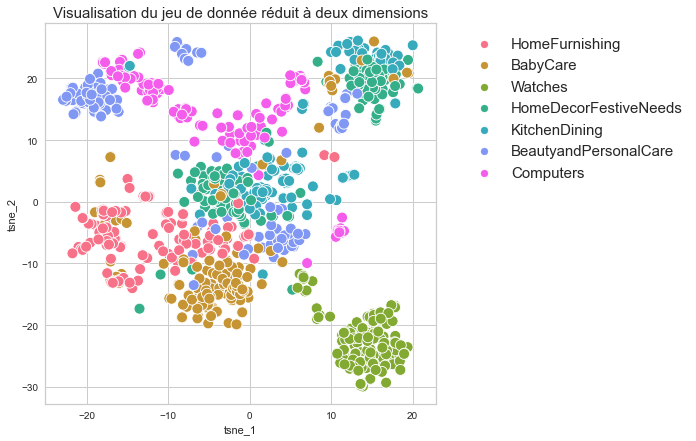

In [34]:
tsne_embedding1_result_df = pd.DataFrame({'tsne_1': tsne_embedding1_transform[:,0], 'tsne_2': tsne_embedding1_transform[:,1], 'label': im['target']})
plt.figure(figsize = (7,7))
sns.scatterplot(x='tsne_1', y='tsne_2',hue='label', data=tsne_embedding1_result_df,s=120)
plt.title("Visualisation du jeu de donnée réduit à deux dimensions", fontsize = 15)
plt.legend(bbox_to_anchor=(1.05, 1),loc = 'best', fontsize = 15)

## Clustering

In [35]:
modele_emb1 = KMeans(n_clusters = 7) 
kmeans_emb1 = modele_emb1.fit(tsne_embedding1_transform)

In [36]:
labels_emb1 = kmeans_emb1.labels_
metrics.silhouette_score(tsne_embedding1_transform, labels_emb1, metric='euclidean')

0.49432313

In [37]:
y_km = kmeans_emb1.fit_predict(tsne_embedding1_transform)
print(y_km)

[5 1 1 ... 4 4 4]


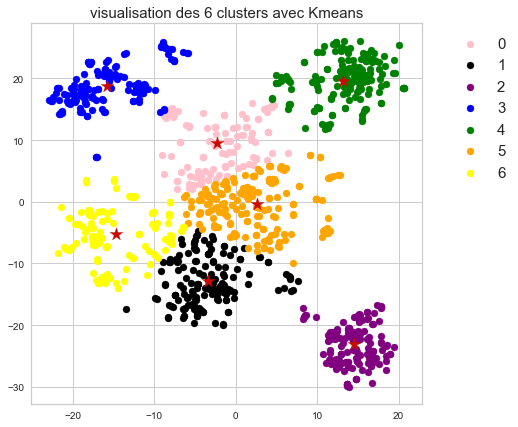

In [38]:
filtered_label0 = tsne_embedding1_transform[y_km == 0]
filtered_label1 = tsne_embedding1_transform[y_km == 1]
filtered_label2 = tsne_embedding1_transform[y_km == 2]
filtered_label3 = tsne_embedding1_transform[y_km == 3]
filtered_label4 = tsne_embedding1_transform[y_km == 4]
filtered_label5 = tsne_embedding1_transform[y_km == 5]
filtered_label6 = tsne_embedding1_transform[y_km == 6]

centroide = kmeans_emb1.cluster_centers_
#plotting the results
plt.figure(figsize = (7,7))
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1],color = 'pink', label = 0)
plt.scatter(filtered_label1[:,0] , filtered_label1[:,1], color = 'black', label = 1)
plt.scatter(filtered_label2[:,0] , filtered_label2[:,1], color= 'purple', label = 2)
plt.scatter(filtered_label3[:,0] , filtered_label3[:,1], color = 'blue', label = 3)
plt.scatter(filtered_label4[:,0] , filtered_label4[:,1], color = 'green', label =4)
plt.scatter(filtered_label5[:,0] , filtered_label5[:,1], color = 'orange', label =5)
plt.scatter(filtered_label6[:,0] , filtered_label6[:,1], color = 'yellow', label =6)
plt.scatter(centroide[:,0] , centroide[:,1] , s = 180, color = 'r',marker = '*')
plt.title("visualisation des 6 clusters avec Kmeans", fontsize = 15)
plt.legend(bbox_to_anchor=(1.05, 1),loc = 'best', fontsize = 15)
plt.show()



In [39]:
ARI_emb1 = adjusted_rand_score(im['target'],kmeans_emb1.labels_)
ARI_emb1

0.40135702661894074

## Réduction dimensionnelle TSNE sur le jeu de donnée word embedding lem nettoyé

In [40]:
tsne = TSNE(n_components=2, perplexity=80, early_exaggeration= 120, learning_rate=200, n_iter=7000, verbose = 1 )
tsne_embedding2_transform = tsne.fit_transform(emb2)

[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.063s...
[t-SNE] Computed neighbors for 1050 samples in 0.767s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 2.142953
[t-SNE] KL divergence after 250 iterations with early exaggeration: 1024.038696
[t-SNE] KL divergence after 2250 iterations: 0.607037


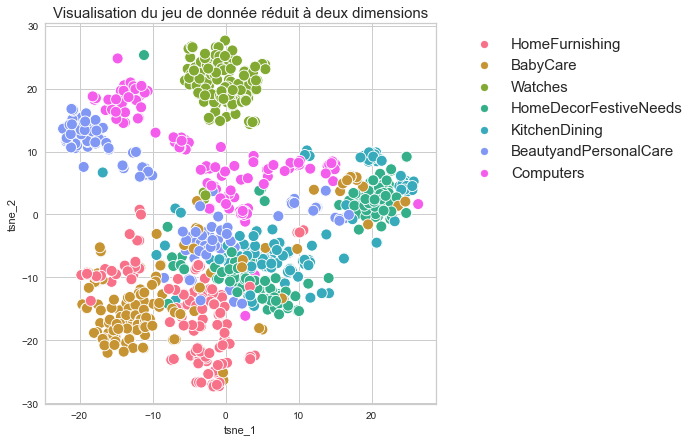

In [41]:
tsne_embedding2_result_df = pd.DataFrame({'tsne_1': tsne_embedding2_transform[:,0], 'tsne_2': tsne_embedding2_transform[:,1], 'label': im['target']})
plt.figure(figsize = (7,7))
sns.scatterplot(x='tsne_1', y='tsne_2',hue='label', data=tsne_embedding2_result_df,s=120)
plt.title("Visualisation du jeu de donnée réduit à deux dimensions", fontsize = 15)
plt.legend(bbox_to_anchor=(1.05, 1),loc = 'best', fontsize = 15)

## Clustering

In [42]:
modele_emb2 = KMeans(n_clusters = 7) 
kmeans_emb2 = modele_emb2.fit(tsne_embedding2_transform)

In [43]:
labels_emb2 = kmeans_emb2.labels_
metrics.silhouette_score(tsne_embedding2_transform, labels_emb2, metric='euclidean')


0.4907405

In [44]:
y_km = kmeans_emb2.fit_predict(tsne_embedding2_transform)
print(y_km)

[4 0 0 ... 1 1 1]


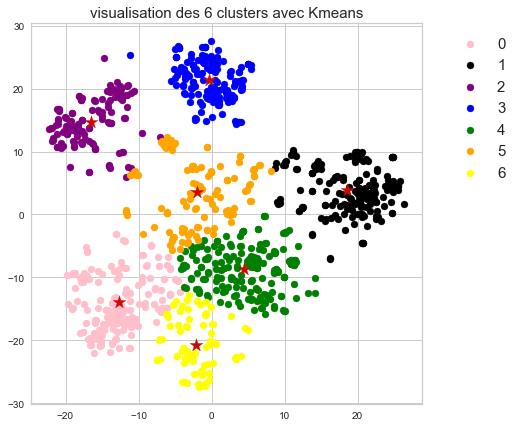

In [45]:
filtered_label0 = tsne_embedding2_transform[y_km == 0]
filtered_label1 = tsne_embedding2_transform[y_km == 1]
filtered_label2 = tsne_embedding2_transform[y_km == 2]
filtered_label3 = tsne_embedding2_transform[y_km == 3]
filtered_label4 = tsne_embedding2_transform[y_km == 4]
filtered_label5 = tsne_embedding2_transform[y_km == 5]
filtered_label6 = tsne_embedding2_transform[y_km == 6]

centroide = kmeans_emb2.cluster_centers_
#plotting the results
plt.figure(figsize = (7,7))
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1],color = 'pink', label = 0)
plt.scatter(filtered_label1[:,0] , filtered_label1[:,1], color = 'black', label = 1)
plt.scatter(filtered_label2[:,0] , filtered_label2[:,1], color= 'purple', label = 2)
plt.scatter(filtered_label3[:,0] , filtered_label3[:,1], color = 'blue', label = 3)
plt.scatter(filtered_label4[:,0] , filtered_label4[:,1], color = 'green', label =4)
plt.scatter(filtered_label5[:,0] , filtered_label5[:,1], color = 'orange', label =5)
plt.scatter(filtered_label6[:,0] , filtered_label6[:,1], color = 'yellow', label =6)
plt.scatter(centroide[:,0] , centroide[:,1] , s = 180, color = 'r',marker = '*')
plt.title("visualisation des 6 clusters avec Kmeans", fontsize = 15)
plt.legend(bbox_to_anchor=(1.05, 1),loc = 'best', fontsize = 15)
plt.show()

In [46]:
ARI_emb2 = adjusted_rand_score(im['target'],kmeans_emb2.labels_)
ARI_emb2

0.40093792597130223

Text(0.5, 1.0, 'Clustering')

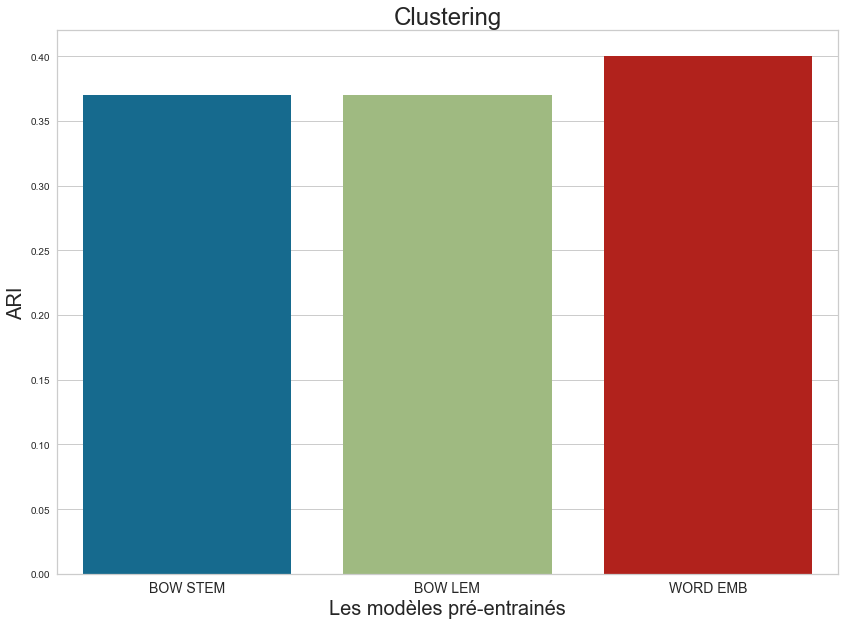

In [76]:
plt.figure(figsize = (14,10))
sns.barplot(x=['BOW STEM','BOW LEM','WORD EMB'], y=[0.37,0.37,0.40])
plt.xlabel("Les modèles pré-entrainés", fontsize=20)
plt.ylabel("ARI", fontsize = 20)
plt.xticks(fontsize = 14)
plt.title("Clustering",fontsize =24)

## Classification

In [47]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

On transforme les catégories en chiffres pour appliquer les méthodes de machine learning

In [48]:
dic= {'HomeFurnishing':0, 'KitchenDining':1, 'HomeDecorFestiveNeeds':2, 'Computers':3, 'Watches':4, 'BeautyandPersonalCare':5, 'BabyCare':6 }
y_train_s = y_train_stem.map(dic)
y_test_s = y_test_stem.map(dic)
y_train_l = y_train_lem.map(dic)
y_test_l = y_test_lem.map(dic)

**méthode stemming**

In [49]:
model_stem=xgb.XGBClassifier(random_state=1,learning_rate=0.01)
model_stem.fit(X_train_stem, y_train_s,eval_set=[(X_train_stem, y_train_s), (X_test_stem, y_test_s)],
          eval_metric='auc')
score = model_stem.score(X_test_stem,y_test_s)
print("score : ",score)
predict_train_stem = model_stem.predict(X_train_stem)
accuracy_train_stem = accuracy_score(y_train_s,predict_train_stem)
print("accuracy train score: ",accuracy_train_stem)
predict_test_stem = model_stem.predict(X_test_stem)
accuracy_test_stem = accuracy_score(y_test_s,predict_test_stem)
print("accuracy test score",accuracy_test_stem)

C:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.99365	validation_1-auc:0.97349
[1]	validation_0-auc:0.99525	validation_1-auc:0.97336
[2]	validation_0-auc:0.99533	validation_1-auc:0.97333
[3]	validation_0-auc:0.99555	validation_1-auc:0.97336
[4]	validation_0-auc:0.99556	validation_1-auc:0.97363
[5]	validation_0-auc:0.99553	validation_1-auc:0.97349
[6]	validation_0-auc:0.99555	validation_1-auc:0.97378
[7]	validation_0-auc:0.99557	validation_1-auc:0.97362
[8]	validation_0-auc:0.99557	validation_1-auc:0.97381
[9]	validation_0-auc:0.99557	validation_1-auc:0.97375
[10]	validation_0-auc:0.99558	validation_1-auc:0.97372
[11]	validation_0-auc:0.99560	validation_1-auc:0.97359
[12]	validation_0-auc:0.99560	validation_1-auc:0.97354
[13]	validation_0-auc:0.99567	validation_1-auc:0.97388
[14]	validation_0-auc:0.99569	validation_1-auc:0.97358
[15]	validation_0-auc:0.99579	validation_1-auc:0.97431
[16]	validation_0-auc:0.99581	validation_1-auc:0.97436
[17]	validation_0-auc:0.99588	validation_1-auc:0.97447
[18]	validation_0-au

<AxesSubplot:>

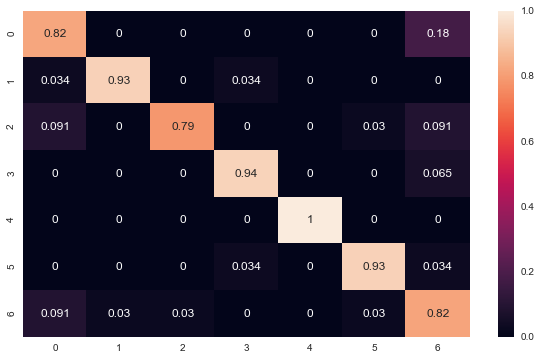

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test_s, predict_test_stem, normalize='true')

index = [0,1,2,3,4,5,6]
cm_df = pd.DataFrame(conf_mat,index,index)

plt.figure(figsize=(10,6))
sns.heatmap(cm_df, annot=True)

In [51]:
from sklearn import metrics
# summarize the fit of the model
print(); print(metrics.classification_report(y_test_s, predict_test_stem))
print(); print(metrics.confusion_matrix(y_test_s, predict_test_stem))


              precision    recall  f1-score   support

           0       0.77      0.82      0.79        28
           1       0.96      0.93      0.95        29
           2       0.96      0.79      0.87        33
           3       0.94      0.94      0.94        31
           4       1.00      1.00      1.00        27
           5       0.93      0.93      0.93        29
           6       0.71      0.82      0.76        33

    accuracy                           0.89       210
   macro avg       0.90      0.89      0.89       210
weighted avg       0.89      0.89      0.89       210


[[23  0  0  0  0  0  5]
 [ 1 27  0  1  0  0  0]
 [ 3  0 26  0  0  1  3]
 [ 0  0  0 29  0  0  2]
 [ 0  0  0  0 27  0  0]
 [ 0  0  0  1  0 27  1]
 [ 3  1  1  0  0  1 27]]


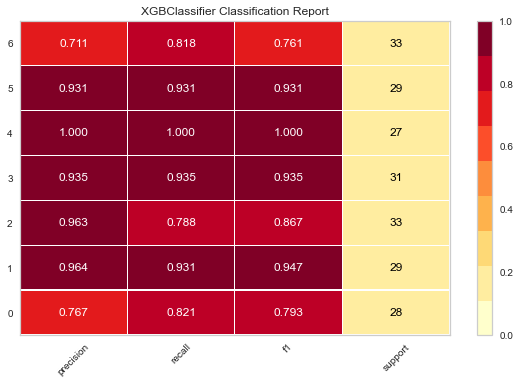

<AxesSubplot:title={'center':'XGBClassifier Classification Report'}>

In [54]:
from yellowbrick.classifier import ClassificationReport
# Specify the target classes
classes = [0,1,2,3,4,5,6]

# Instantiate the classification model and visualizer

visualizer = ClassificationReport(model_stem, classes=classes, support=True)

visualizer.fit(X_train_stem, y_train_s)        # Fit the visualizer and the model
visualizer.score(X_test_stem, y_test_s)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

**méthode lemmatisation**

In [55]:
model_lem=xgb.XGBClassifier(random_state=1,learning_rate=0.01)
model_lem.fit(X_train_lem, y_train_l)
model_lem.score(X_test_lem,y_test_l)

[17:30:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8952380952380953

In [56]:
predict_train_lem = model_lem.predict(X_train_lem)
accuracy_train_lem = accuracy_score(y_train_l,predict_train_lem)
accuracy_train_lem

0.9761904761904762

In [57]:
predict_test_lem = model_lem.predict(X_test_lem)
accuracy_test_lem = accuracy_score(y_test_l,predict_test_lem)
accuracy_test_lem

0.8952380952380953

<AxesSubplot:>

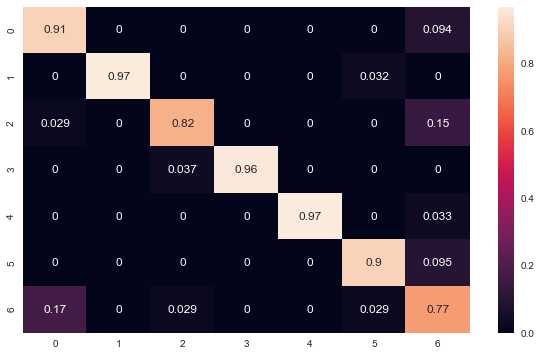

In [58]:
conf_mat = confusion_matrix(y_test_l, predict_test_lem, normalize='true')

index = [0,1,2,3,4,5,6]
cm_df = pd.DataFrame(conf_mat,index,index)

plt.figure(figsize=(10,6))
sns.heatmap(cm_df, annot=True)

In [59]:
from sklearn import metrics
# summarize the fit of the model
print(); print(metrics.classification_report(y_test_l, predict_test_lem))
print(); print(metrics.confusion_matrix(y_test_l, predict_test_lem))


              precision    recall  f1-score   support

           0       0.81      0.91      0.85        32
           1       1.00      0.97      0.98        31
           2       0.93      0.82      0.87        34
           3       1.00      0.96      0.98        27
           4       1.00      0.97      0.98        30
           5       0.90      0.90      0.90        21
           6       0.71      0.77      0.74        35

    accuracy                           0.90       210
   macro avg       0.91      0.90      0.90       210
weighted avg       0.90      0.90      0.90       210


[[29  0  0  0  0  0  3]
 [ 0 30  0  0  0  1  0]
 [ 1  0 28  0  0  0  5]
 [ 0  0  1 26  0  0  0]
 [ 0  0  0  0 29  0  1]
 [ 0  0  0  0  0 19  2]
 [ 6  0  1  0  0  1 27]]


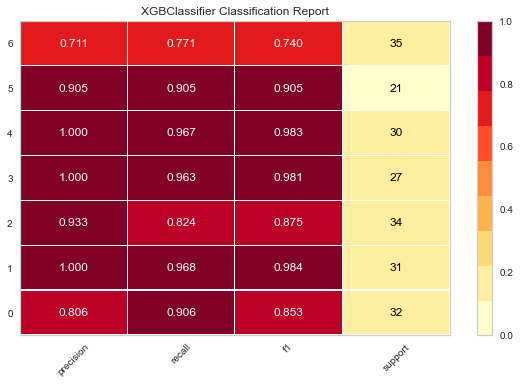

<AxesSubplot:title={'center':'XGBClassifier Classification Report'}>

In [60]:
from yellowbrick.classifier import ClassificationReport
# Specify the target classes
classes = [0,1,2,3,4,5,6]

# Instantiate the classification model and visualizer

visualizer = ClassificationReport(model_lem, classes=classes, support=True)

visualizer.fit(X_train_lem, y_train_l)        # Fit the visualizer and the model
visualizer.score(X_test_lem, y_test_l)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

**méthode embedding**

In [61]:
X_train_emb0, X_test_emb0, y_train_emb0, y_test_emb0 = train_test_split(emb0,im['target'], test_size=0.2)

In [62]:
dic= {'HomeFurnishing':0, 'KitchenDining':1, 'HomeDecorFestiveNeeds':2, 'Computers':3, 'Watches':4, 'BeautyandPersonalCare':5, 'BabyCare':6 }
y_train_emb0 = y_train_emb0.map(dic)
y_test_emb0 = y_test_emb0.map(dic)

In [63]:
model_emb0=xgb.XGBClassifier(random_state=1,learning_rate=0.1)
model_emb0.fit(X_train_emb0, y_train_emb0)
model_emb0.score(X_test_emb0,y_test_emb0)

[17:36:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.861904761904762

In [64]:
predict_train_emb0 = model_emb0.predict(X_train_emb0)
accuracy_train_emb0 = accuracy_score(y_train_emb0,predict_train_emb0)
accuracy_train_emb0

1.0

In [65]:
predict_test_emb0 = model_emb0.predict(X_test_emb0)
accuracy_test_emb0 = accuracy_score(y_test_emb0,predict_test_emb0)
accuracy_test_emb0

0.861904761904762

<AxesSubplot:>

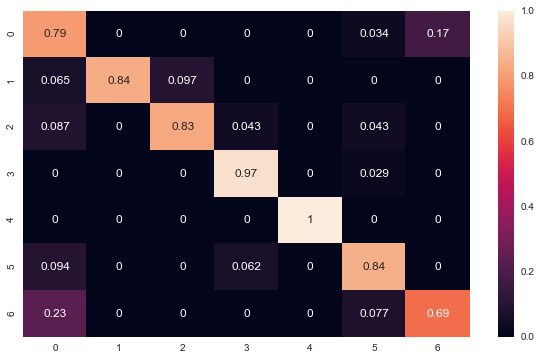

In [66]:
conf_mat = confusion_matrix(y_test_emb0, predict_test_emb0, normalize='true')

index = [0,1,2,3,4,5,6]
cm_df = pd.DataFrame(conf_mat,index,index)

plt.figure(figsize=(10,6))
sns.heatmap(cm_df, annot=True)

In [67]:
from sklearn import metrics
# summarize the fit of the model
print(); print(metrics.classification_report(predict_test_emb0, predict_test_emb0))
print(); print(metrics.confusion_matrix(predict_test_emb0, predict_test_emb0))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       1.00      1.00      1.00        26
           2       1.00      1.00      1.00        22
           3       1.00      1.00      1.00        36
           4       1.00      1.00      1.00        35
           5       1.00      1.00      1.00        32
           6       1.00      1.00      1.00        23

    accuracy                           1.00       210
   macro avg       1.00      1.00      1.00       210
weighted avg       1.00      1.00      1.00       210


[[36  0  0  0  0  0  0]
 [ 0 26  0  0  0  0  0]
 [ 0  0 22  0  0  0  0]
 [ 0  0  0 36  0  0  0]
 [ 0  0  0  0 35  0  0]
 [ 0  0  0  0  0 32  0]
 [ 0  0  0  0  0  0 23]]


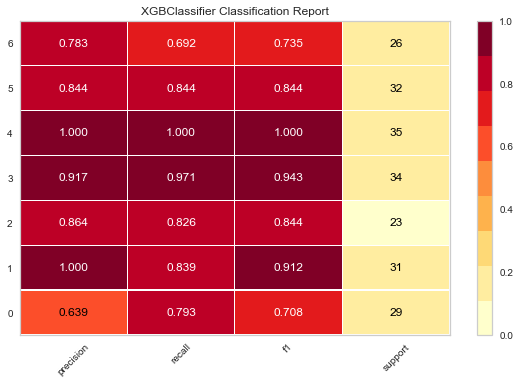

<AxesSubplot:title={'center':'XGBClassifier Classification Report'}>

In [71]:
from yellowbrick.classifier import ClassificationReport
# Specify the target classes
classes = [0,1,2,3,4,5,6]

# Instantiate the classification model and visualizer

visualizer = ClassificationReport(model_emb0, classes=classes, support=True)

visualizer.fit(X_train_emb0, y_train_emb0)        # Fit the visualizer and the model
visualizer.score(X_test_emb0,y_test_emb0 )  # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

Text(0.5, 1.0, 'Classification')

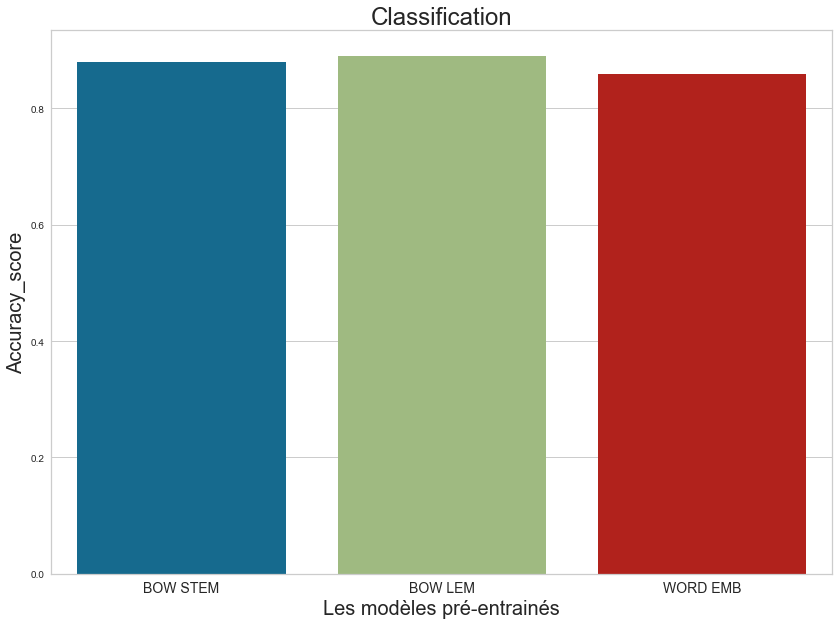

In [77]:
plt.figure(figsize = (14,10))
sns.barplot(x=['BOW STEM','BOW LEM','WORD EMB'], y=[0.88,0.89,0.86])
plt.xlabel("Les modèles pré-entrainés", fontsize=20)
plt.ylabel("Accuracy_score", fontsize = 20)
plt.xticks(fontsize = 14)
plt.title("Classification",fontsize =24)